In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
class LDA:

    def __init__(self) -> None:
        self.X = None
        self.y = None
        self.classes = None
        self.mu, self.cov, self.prior_probas = {}, {}, {}

    @staticmethod
    def linear(x : list | np.ndarray, mu : float, cov : np.ndarray) -> float:
        if isinstance(x, list):
            x = np.array([x])

        mu = np.array([mu])
        inv = np.linalg.inv(cov)

        return -0.5 * np.matmul(np.matmul(mu, inv), mu.T) + np.matmul(np.matmul(x, inv), mu.T)


    def fit(self, X : pd.DataFrame, y : pd.DataFrame) -> None:
        self.X = X
        self.y = y
        m, n = self.X.shape

        self.classes = pd.unique(y)
        self.cov = np.zeros((n, n))

        for c in self.classes:
            self.mu[c] = self.X.iloc[self.y[self.y == c].index].mean()
            self.prior_probas[c] = len(self.X.iloc[self.y[self.y == c].index]) / m

        for i in range(m):
            mu = self.mu[self.y.values[i]]
            current = self.X.values[i]
            self.cov += np.array([current - mu]) * np.transpose(np.array([current - mu]))

        self.cov /= m - n


    def predict(self, point : list | np.ndarray) -> int:
        posterior_probas, classes = [], []

        for c in self.classes:
            prior_proba = np.log(self.prior_probas[c])
            mu = self.mu[c]
            cov = self.cov
            posterior_proba = prior_proba + self.linear(point, mu, cov)
            posterior_probas.append(posterior_proba)
            classes.append(c)

        return classes[np.argmax(posterior_probas)]

В который раз будем строить предсказания по формуле:
$$a(x) = \arg \max_{y \in Y} λ_y P_y p_y(x)$$
Так как мы не можем точно узнать значения апрорных вероятностей каждого класса и плотности распределений(да-да в который раз), посчитаем приближенные оценки $\hat{P_y} \hat{p_y}(x)$. Для $\hat{P_y}$ оставим такой же подход просто:
$$ \hat{P_y} = \frac{|X_l^y|}{|X_l|}$$
Все так же будем полагать распределение точек многомерным нормальным:
$$ N(x, μ, Σ) = \frac{1}{\sqrt{(2 π)^n |Σ|}} e^{-\frac{1}{2} (x-μ)^T Σ^{-1} (x-\mu)} $$
Но на этот раз мы воспользуемся предложением Фишера - положим матрицы ковариции всех классов равными. Тогда мы можем восстановить $Σ$ по формуле:
$$\hat{Σ} = \frac{1}{l - |Y|} \sum_{i = 1}^{l} (x_i - \hat{\mu}_{y_i})(x_i - \hat{\mu}_{y_i})^T$$
$$\hat{\mu}_{y_i} = \frac{1}{|X_{y_i}|} \sum_{i=1}^{|X_{y_i}|} x_i$$
Тогда классификатор имеем вид:
$$a(x) = \arg \max_{y \in Y} \ln{λ_y \hat{P_y}} - \frac{1}{2} \hat{\mu}_{y_i}^T Σ^{-1}\hat{\mu}_{y_i} + x^TΣ^{-1}\hat{\mu}_{y_i}$$
И тут видно почему этот метод называется линейным дискриминантом Фишера или линейным дискриминантным анализом - по сути мы получили что-то похожее на $y = kx + b$. У нас есть константная часть - $\ln{λ_y \hat{P_y}} - \frac{1}{2} \hat{\mu}_{y_i}^T Σ^{-1}\hat{\mu}_{y_i}$ и другая - $x^TΣ^{-1}\hat{\mu}_{y_i}$. Поэтому в качестве разделяющей гиперплоскости мы будем получать прямую, далее мы поймем хорошо это или нет.


In [ ]:
class Plug_in:


    def __init__(self) -> None:
        self.X = None
        self.y = None
        self.classes = None


    @staticmethod
    def gaussian(x : np.ndarray | list, mu : np.ndarray | list, cov : np.ndarray) -> float:
        diff = np.array([x - mu])
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)

        return 1 / (np.sqrt((2 * np.pi)**len(x)) * det) * np.exp(-0.5 * np.transpose(diff) * inv * diff)


    def fit(self, X : pd.DataFrame, y : np.ndarray | pd.DataFrame) -> None:
        self.X = X
        self.y = y
        m, n = X.shape

        self.classes = np.unique(self.y)
        self.mu = {}
        self.cov = {c: np.zeros((n, n)) for c in self.classes}
        self.prior_probas = {}

        for c in self.classes:
            self.mu[c] = self.X.iloc[self.y[self.y == c].index].mean()

            for cur in self.X.iloc[self.y[self.y == c].index].values:
                self.cov[c] += np.array([(cur - self.mu[c])]) * np.transpose(np.array([cur - self.mu[c]]))

            self.cov[c] /= m - 1

            self.prior_probas[c] = len(self.X.iloc[self.y[self.y == c].index]) / m


    def predict(self, point : np.ndarray | list) -> int:
        posterior_probas, classes = [], []

        for c in self.classes:
            prior_proba = np.log(self.prior_probas[c])
            mu = self.mu[c]
            cov = self.cov[c]
            posterior_proba = prior_proba + np.sum(np.log(self.gaussian(point, mu, cov)))
            posterior_probas.append(posterior_proba)
            classes.append(c)

        return classes[np.argmax(posterior_probas)]

In [ ]:
def make_classification_map(best_model : object, x : np.ndarray, y : np.ndarray, data : pd.DataFrame) -> None:
    all_points = []
    for i in np.arange(0, 1, 0.01):
        for j in np.arange(0, 1, 0.01):
          all_points.append([i, j])

    predictions = []
    for i in all_points:
        predictions.append(model.predict(i))


    df = pd.DataFrame(data={'x' : [point[0] for point in all_points], 'y' : [point[1] for point in all_points], 'Label' : predictions})
    sns.scatterplot(data=df, x='x', y='y', hue='Label', palette="magma")
    sns.scatterplot(data=data, x='x', y='y', hue='label')

In [ ]:
def generate(mu : float, sigma : float, size=100) -> np.ndarray:
    return np.array(np.random.normal(mu, sigma, size))


def generate_feature(x : np.ndarray, y : np.ndarray):
    return np.concatenate((x, y))


def generate_sample_data(size = 100, option : bool = False) -> pd.DataFrame:
    x = generate_feature(generate(0.2, 0.05, size=size // 2), generate(0.4, 0.05, size=size // 2))
    y = generate_feature(generate(0.4, 0.05, size=size // 2), generate(0.6, 0.05, size=size // 2))
    labels = np.array([0] * (size // 2) + [1] * (size // 2))
    if option:
        return x, y, labels, pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})
    return pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})

In [ ]:
x, y, labels, data = generate_sample_data(100, option=True)

In [ ]:
model = LDA()
model.fit(data[['x', 'y']], data.label)

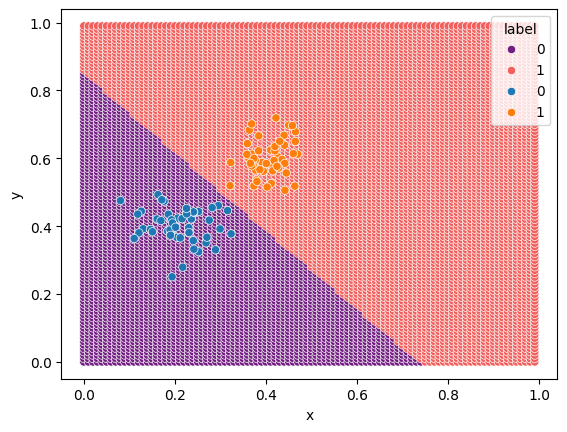

In [ ]:
make_classification_map(model, x, y, data)

Как и говорилось в аннотации к методу, мы получили прямую, которая будет еще более гладкой, если в карте классификации взять промежуток между точками меньше, но сейчас нам этого не нужно

А теперь, ниже, мы сравним подстановочный алгоритм с линейным дискриминантным анализом.

In [322]:
def generate_shuffled_data(size = 100, option : bool = False) -> pd.DataFrame:
    x = generate_feature(generate(0.25, 0.05, size=size // 2), generate(0.3, 0.05, size=size // 2))
    y = generate_feature(generate(0.8, 0.05, size=size // 2), generate(0.8, 0.05, size=size // 2))
    labels = np.array([0] * (size // 2) + [1] * (size // 2))
    if option:
        return x, y, labels, pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})
    return pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})

In [323]:
x, y, labels, data = generate_shuffled_data(150, option=True)

<Axes: xlabel='x', ylabel='y'>

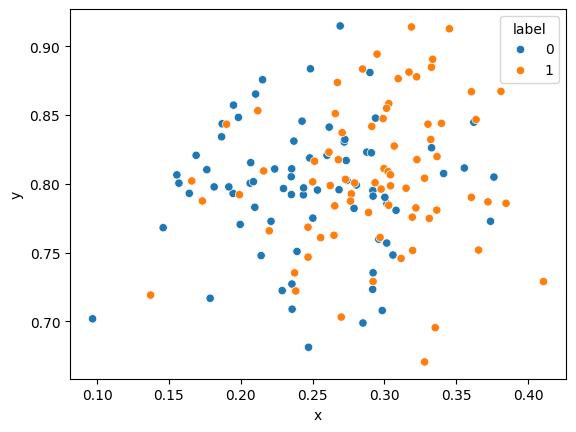

In [324]:
sns.scatterplot(data=data, x='x', y='y', hue='label')

Создадим такие данные, в которых будет явно видна граница классов, потому что очевидно, что мы не сможем провести разделяющую гиперплоскость для такой выборки

In [346]:
model = LDA()
model.fit(data[['x', 'y']], data.label)

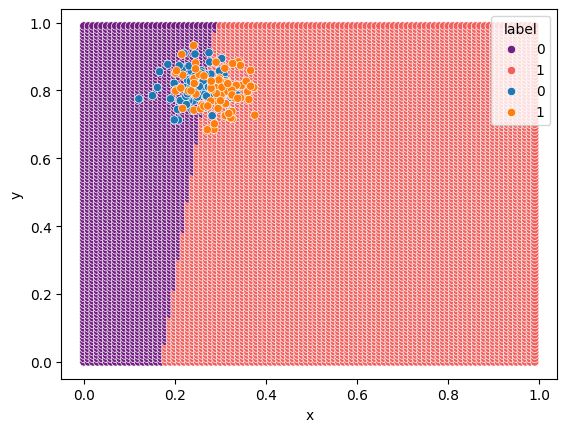

In [347]:
make_classification_map(model, x, y, data)

In [348]:
model = Plug_in()
model.fit(data[['x', 'y']], data.label)

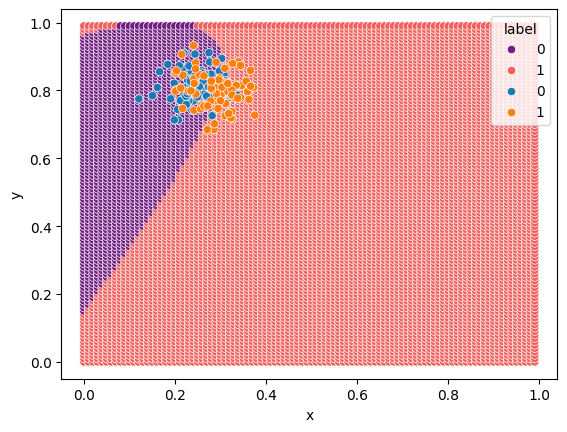

In [349]:
make_classification_map(model, x, y, data)

In [342]:
model1 = Plug_in()
model1.fit(data[['x', 'y']], data.label)
model2 = LDA()
model2.fit(data[['x', 'y']], data.label)

In [343]:
n = len(x)
correct = 0
for i in range(n):
    if model1.predict([x[i], y[i]]) == labels[i]:
        correct += 1
print(correct / n)

0.6866666666666666


In [344]:
n = len(x)
correct = 0
for i in range(n):
    if model2.predict([x[i], y[i]]) == labels[i]:
        correct += 1
print(correct / n)

0.7133333333333334


Как мы видим LDA сделал меньше ошибок, что на самом деле ожидаемо. Сама суть подстановочного алгоритма в какой-то степени - переобучение, потому что даже 1 точка может сильно изменить гиперплоскость, в отличии от LDA, где она сдвинется и мы получим классификацию хуже, но хотя бы какую-то. \\
Как видно из примера выше, точность LDA хоть и выше, но все равно, метод точно так же плохо будет работать, когда данные перемешаны, не близки к нормальным. Мы точно также обращаем матрицу ковариации для расчетов. А еще мы жертвуем качеством классификации, ведь квадратичные гиперплоскости лучше прямой, взамен же мы получаем большую обобщающую способность, большую устойчивость к выбросам, большую скорость работы(карта классификации строилась в 2 раза быстрее). \\
Выделим преимущества и недостатки: \\
+:

1.   Если данные распределены нормально или хотя бы близко к нормальному, то качество классификации будет хорошим
2.   Если данные можно идеально разделить линейной гиперплоскостью, то классификатор будет идеальным
3.   Более высокая точность работы по сравнению с методом наивного Байеса
4.   Более высокая обощающая способность, чем у подстановочного алгоритма
5.   Относительно небольшая скорость работы

-:


1.   Если матрица $Σ$ вырожденная, мы не сможем найти обратную, если она плохо обусловленная, метод потеряет обобщающую способность и будет работать хуже
2.   Если нам нужно классифицировать на строго одном наборе данных, то подставновочный алгорим будет лучше
3.   Если данные нельзя разделить линейной гиперплоскостью, алгоритм будет работать плохо



